In [7]:
import brian2 as b2
from brian2 import *
from keras.datasets import mnist
from tqdm import tqdm
from sklearn import metrics
import numpy as np
import pandas as pd
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from spikingjelly import visualizing
import utils

In [8]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# simplified classification (0 1 and 8)
X_train = X_train[(y_train == 1) | (y_train == 0)]
y_train = y_train[(y_train == 1) | (y_train == 0)]
X_test = X_test[(y_test == 1) | (y_test == 0)]
y_test = y_test[(y_test == 1) | (y_test == 0)]

# pixel intensity to Hz (255 becoms ~63Hz)
X_train = X_train / 4 
X_test = X_test / 4

X_train.shape, X_test.shape

((12665, 28, 28), (2115, 28, 28))

In [12]:
n_input = 28*28 # input layer
n_e = 100 # e - excitatory
n_i = n_e # i - inhibitory

v_rest_e = -60.*mV # v - membrane potential
v_reset_e = -65.*mV
v_thresh_e = -52.*mV

v_rest_i = -60.*mV
v_reset_i = -45.*mV
v_thresh_i = -40.*mV

taupre = 20*ms
taupost = taupre
gmax = .3 #.01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax 
dApre *= gmax 

# Apre and Apost - presynaptic and postsynaptic traces, lr - learning rate
stdp='''w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)'''
pre='''ge += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, gmax)'''
post='''Apost += dApost
    w = clip(w + lr*Apre, 0, gmax)'''

class Model():
    
    def __init__(self, debug=False):
        app = {}
                
        # input images as rate encoded Poisson generators
        app['PG'] = PoissonGroup(n_input, rates=np.zeros(n_input)*Hz, name='PG')
        
        # excitatory group
        neuron_e = '''
            dv/dt = (ge*(0*mV-v) + gi*(-100*mV-v) + (v_rest_e-v)) / (100*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            dgi/dt = -gi / (10*ms) : 1
            '''
        app['EG'] = NeuronGroup(n_e, neuron_e, threshold='v>v_thresh_e', refractory=5*ms, reset='v=v_reset_e', method='euler', name='EG')
        app['EG'].v = v_rest_e - 20.*mV
        
        if (debug):
            app['ESP'] = SpikeMonitor(app['EG'], name='ESP')
            app['ESM'] = StateMonitor(app['EG'], ['v'], record=True, name='ESM')
            app['ERM'] = PopulationRateMonitor(app['EG'], name='ERM')
        
        # ibhibitory group
        neuron_i = '''
            dv/dt = (ge*(0*mV-v) + (v_rest_i-v)) / (10*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            '''
        app['IG'] = NeuronGroup(n_i, neuron_i, threshold='v>v_thresh_i', refractory=2*ms, reset='v=v_reset_i', method='euler', name='IG')
        app['IG'].v = v_rest_i - 20.*mV

        if (debug):
            app['ISP'] = SpikeMonitor(app['IG'], name='ISP')
            app['ISM'] = StateMonitor(app['IG'], ['v'], record=True, name='ISM')
            app['IRM'] = PopulationRateMonitor(app['IG'], name='IRM')
        
        # poisson generators one-to-all excitatory neurons with plastic connections 
        app['S1'] = Synapses(app['PG'], app['EG'], stdp, on_pre=pre, on_post=post, method='euler', name='S1')
        app['S1'].connect()
        app['S1'].w = 'rand()*gmax' # random weights initialisation
        app['S1'].lr = 1 # enable stdp        
        
        if (debug):
            # some synapses
            app['S1M'] = StateMonitor(app['S1'], ['w', 'Apre', 'Apost'], record=app['S1'][380,:4], name='S1M') 
        
        # excitatory neurons one-to-one inhibitory neurons
        app['S2'] = Synapses(app['EG'], app['IG'], 'w : 1', on_pre='ge += w', name='S2')
        app['S2'].connect(j='i')
        app['S2'].delay = 'rand()*10*ms'
        app['S2'].w = 3 # very strong fixed weights to ensure corresponding inhibitory neuron will always fire

        # inhibitory neurons one-to-all-except-one excitatory neurons
        app['S3'] = Synapses(app['IG'], app['EG'], 'w : 1', on_pre='gi += w', name='S3')
        app['S3'].connect(condition='i!=j')
        app['S3'].delay = 'rand()*5*ms'
        app['S3'].w = .03 # weights are selected in such a way as to maintain a balance between excitation and ibhibition
        
        self.net = Network(app.values())
        self.net.run(0*second)
        
    def __getitem__(self, key):
        return self.net[key]
    
    def train(self, X, epoch=1):        
        self.net['S1'].lr = 1 # stdp on
        
        for ep in range(epoch):
            for idx in range(len(X)):
                # active mode
                self.net['PG'].rates = X[idx].ravel()*Hz
                self.net.run(0.35*second)

                # passive mode
                self.net['PG'].rates = np.zeros(n_input)*Hz
                self.net.run(0.15*second)
        
    def evaluate(self, X):       
        self.net['S1'].lr = 0  # stdp off
        
        features = []
        for idx in range(len(X)):
            # rate monitor to count spikes
            mon = SpikeMonitor(self.net['EG'], name='RM')
            self.net.add(mon)
            
            # active mode
            self.net['PG'].rates = X[idx].ravel()*Hz
            self.net.run(0.35*second)
            
            # spikes per neuron foreach image
            features.append(np.array(mon.count, dtype=int8))
            
            # passive mode
            self.net['PG'].rates = np.zeros(n_input)*Hz
            self.net.run(0.15*second)
            
            self.net.remove(self.net['RM'])
            
        return features

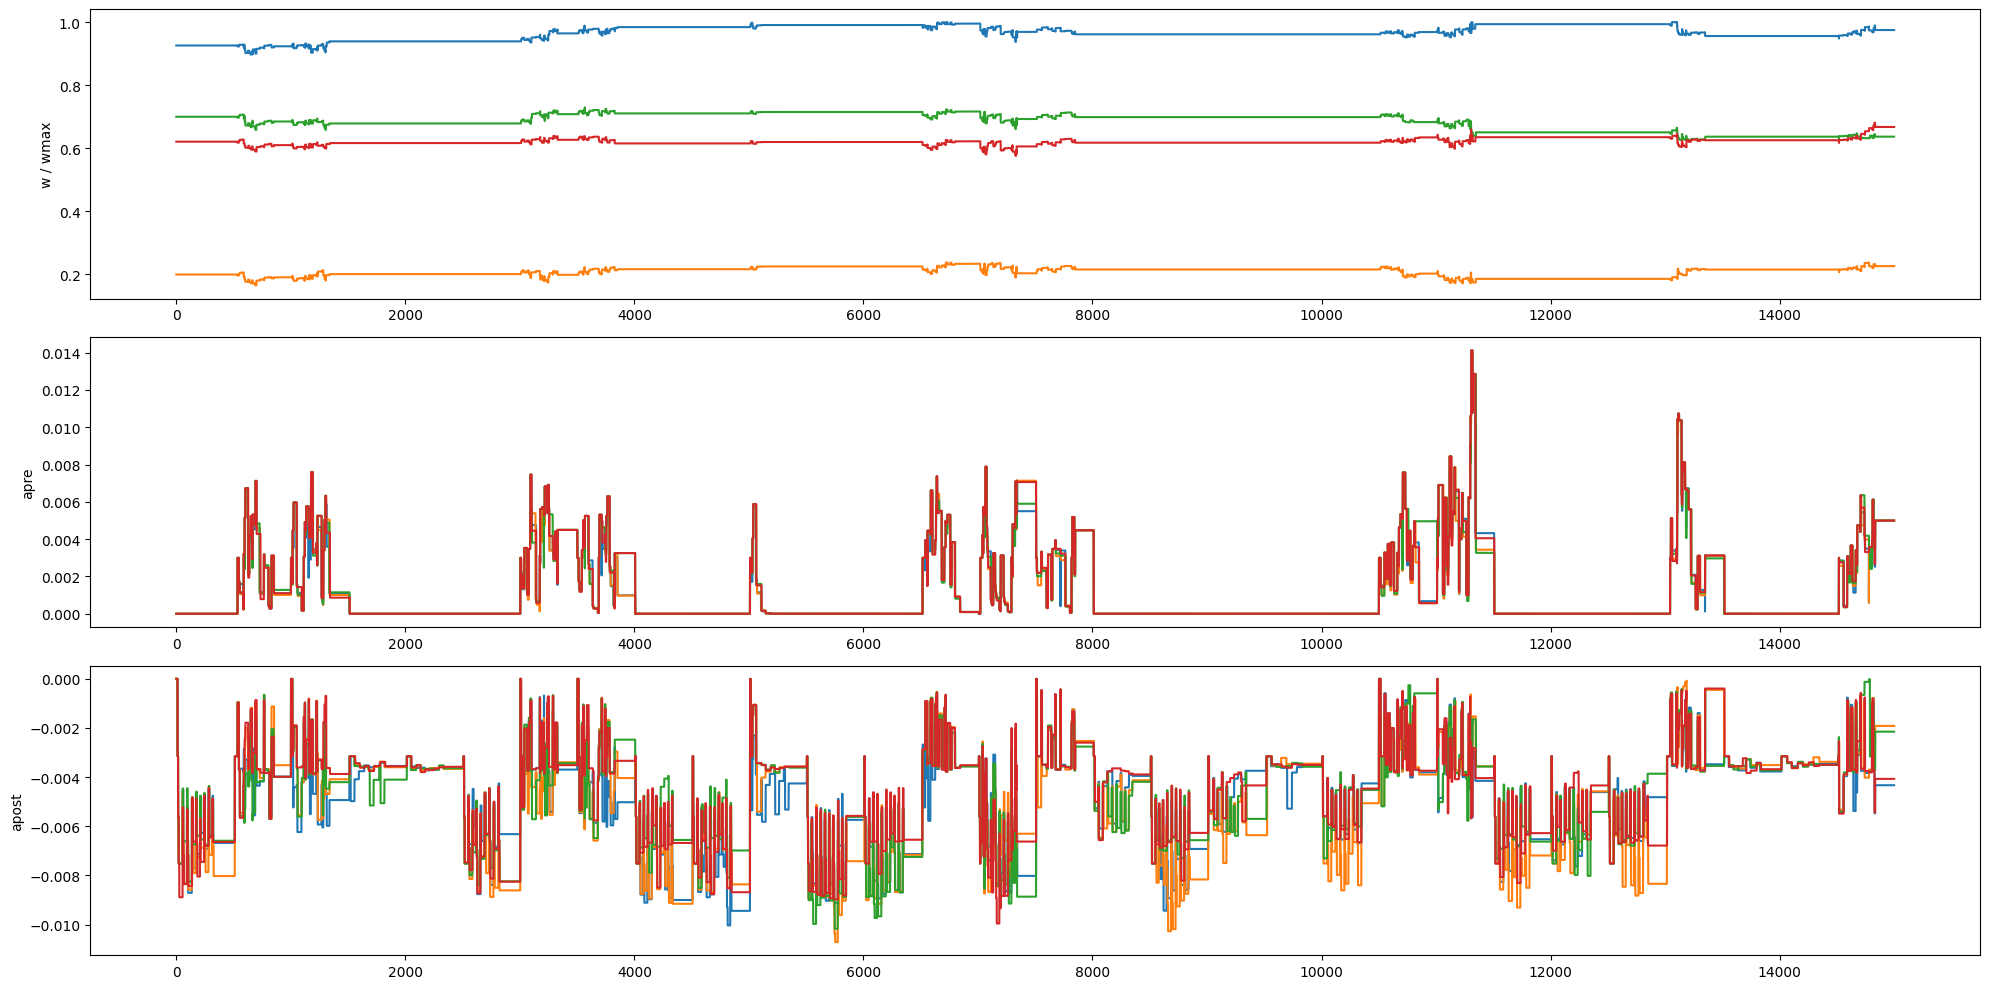

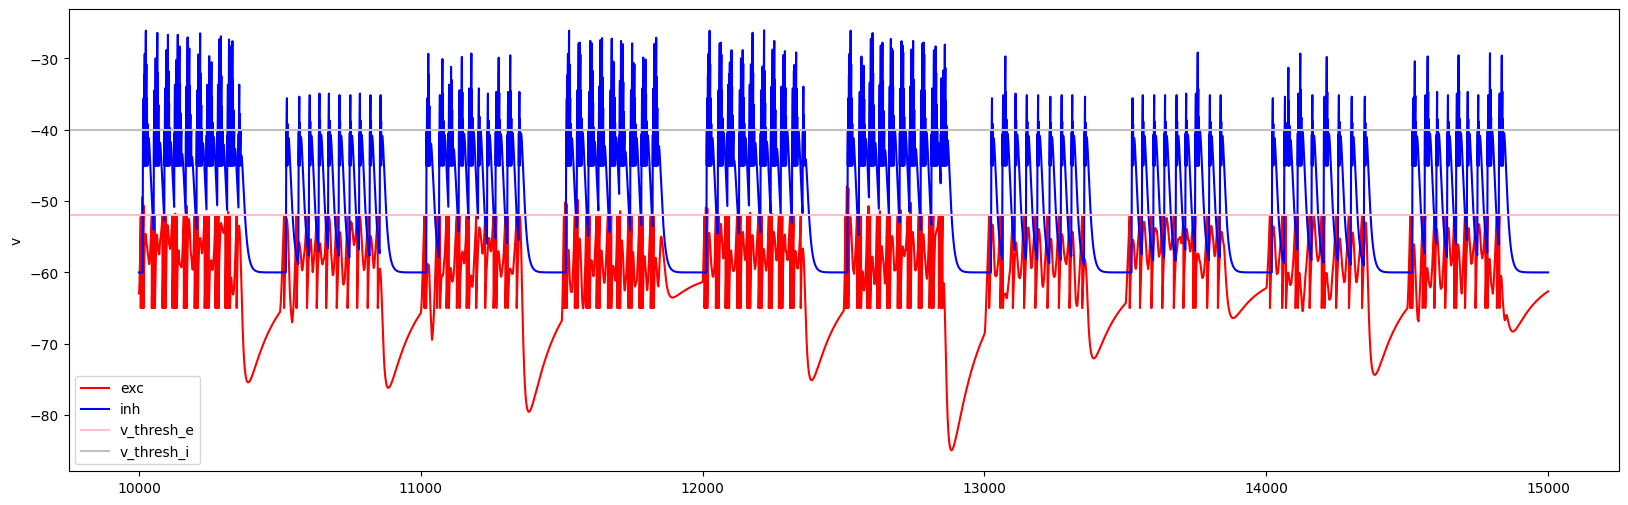

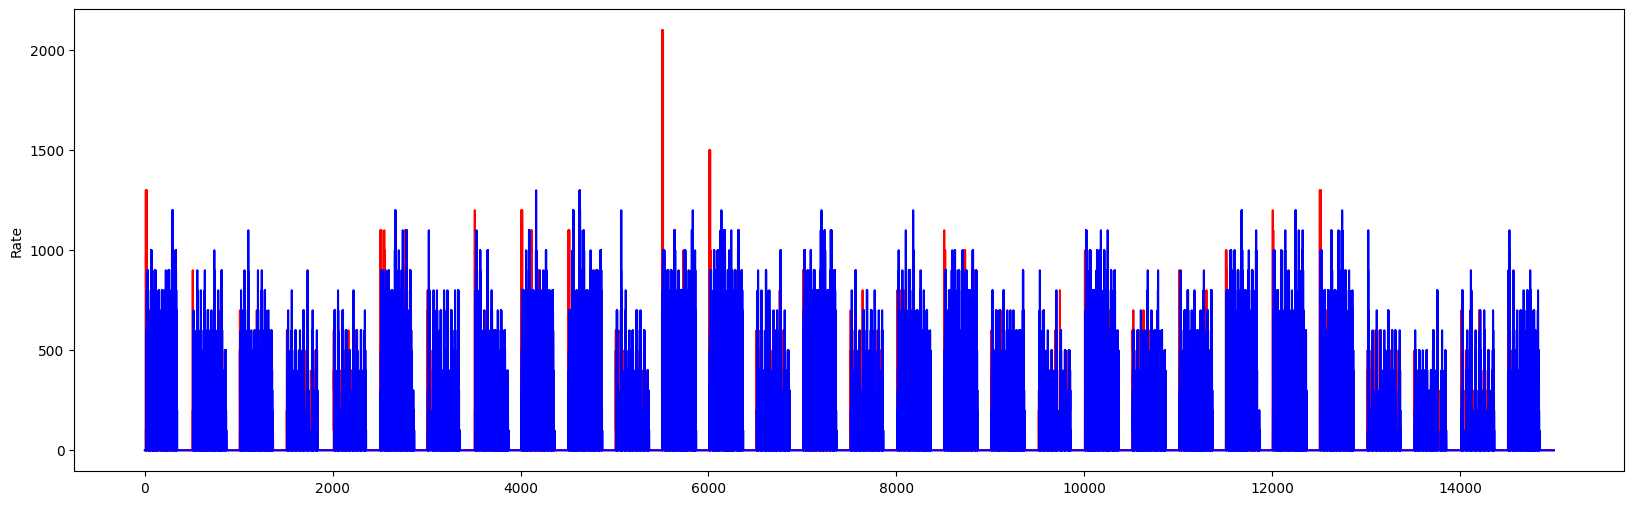

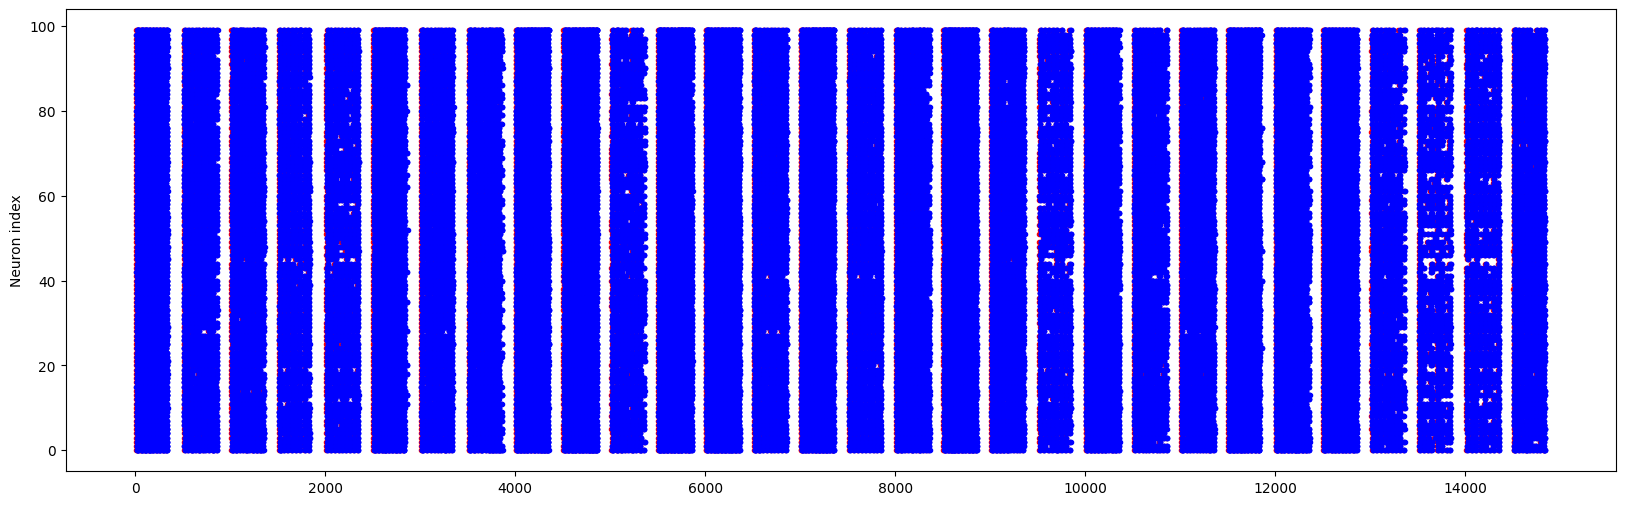

In [13]:
def plot_w(S1M):
    plt.rcParams["figure.figsize"] = (20,10)
    subplot(311)
    plot(S1M.t/ms, S1M.w.T/gmax)
    ylabel('w / wmax')
    subplot(312)
    plot(S1M.t/ms, S1M.Apre.T)
    ylabel('apre')
    subplot(313)
    plot(S1M.t/ms, S1M.Apost.T)
    ylabel('apost')
    tight_layout()
    show();
    
def plot_v(ESM, ISM, neuron=13):
    plt.rcParams["figure.figsize"] = (20,6)
    cnt = -50000 # tail
    plot(ESM.t[cnt:]/ms, ESM.v[neuron][cnt:]/mV, label='exc', color='r')
    plot(ISM.t[cnt:]/ms, ISM.v[neuron][cnt:]/mV, label='inh', color='b')
    plt.axhline(y=v_thresh_e/mV, color='pink', label='v_thresh_e')
    plt.axhline(y=v_thresh_i/mV, color='silver', label='v_thresh_i')
    legend()
    ylabel('v')
    show();
    
def plot_rates(ERM, IRM):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(ERM.t/ms, ERM.smooth_rate(window='flat', width=0.1*ms)*Hz, color='r')
    plot(IRM.t/ms, IRM.smooth_rate(window='flat', width=0.1*ms)*Hz, color='b')
    ylabel('Rate')
    show();
    
def plot_spikes(ESP, ISP):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(ESP.t/ms, ESP.i, '.r')
    plot(ISP.t/ms, ISP.i, '.b')
    ylabel('Neuron index')
    show();

def test0(train_items=30):
    '''
    STDP visualisation
    '''
    seed(0)
    
    model = Model(debug=True)
    model.train(X_train[:train_items], epoch=1)
    
    plot_w(model['S1M'])
    plot_v(model['ESM'], model['ISM'])
    plot_rates(model['ERM'], model['IRM'])
    plot_spikes(model['ESP'], model['ISP'])
    
test0()

In [14]:
def test1(train_items=5000, assign_items=1000, eval_items=1000):
    '''
    Feed train set to SNN with STDP
    Freeze STDP
    Feed train set to SNN again and collect generated features
    Train RandomForest on the top of these features and labels provided
    Feed test set to SNN and collect new features
    Predict labels with RandomForest and calculate accuacy score
    '''
    seed(0)
    
    model = Model()
    model.train(X_train[:train_items], epoch=1)
    model.net.store('train', 'train.b2')
    #model.net.restore('train', './train.b2')
    
    f_train = model.evaluate(X_train[:assign_items])
    clf = RandomForestClassifier(max_depth=4, random_state=0)
    clf.fit(f_train, y_train[:assign_items])
    print(clf.score(f_train, y_train[:assign_items]))

    f_test = model.evaluate(X_test[:eval_items])
    y_pred = clf.predict(f_test)
    print(accuracy_score(y_pred, y_test[:eval_items]))

    cm = confusion_matrix(y_pred, y_test[:eval_items])
    print(cm)
    
test1()

0.999
0.999
[[448   1]
 [  0 551]]
